In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.spatial import distance
from gemelli.rpca import joint_rpca
from biom import Table
from statannotations.Annotator import Annotator
from skbio.stats.distance import permanova, permdisp
from skbio import OrdinationResults, DistanceMatrix
from sklearn.model_selection import train_test_split
from gemelli.joint_ctf import joint_ctf
from gemelli.ctf import ctf_table_processing
from gemelli.preprocessing import build_sparse

%matplotlib inline

In [11]:
joint_rpca_path = '/Users/bec5786/NYU Langone Health Dropbox/Bianca Cordazzo Vargas/Shenhav_Lab/IMiC/Code/Joint-RPCA/'

In [12]:
#load metadata
misame_metadata = pd.read_csv("{}output/all_tps/misame_metadata_vitae.csv".format(joint_rpca_path), index_col=0)

#load targeted metabolomics data
allen_macro = pd.read_csv("{}output/all_tps/misame_macro_all_raw.csv".format(joint_rpca_path), index_col=0)
allen_micro = pd.read_csv("{}output/all_tps/misame_micro_vitae_raw.csv".format(joint_rpca_path), index_col=0)
bode_hmos = pd.read_csv("{}output/all_tps/misame_hmo_all_raw.csv".format(joint_rpca_path), index_col=0)
biocrates = pd.read_csv("{}output/all_tps/misame_biocrates_all_raw.csv".format(joint_rpca_path), index_col=0)

#load top 104 untargeted metabolites (optional)
untargeted = pd.read_csv("{}output/all_tps/misame_untargeted_sapient.csv".format(joint_rpca_path), index_col=0)
untargeted = untargeted.loc[misame_metadata.index]

In [13]:
#keep subsets with at least 2 samples
ids_to_keep = misame_metadata['SubjectID'].value_counts()[misame_metadata['SubjectID'].value_counts() > 1].index

#subset all data
misame_metadata = misame_metadata.loc[misame_metadata['SubjectID'].isin(ids_to_keep)]
allen_macro = allen_macro.loc[misame_metadata.index]
allen_micro = allen_micro.loc[misame_metadata.index]
bode_hmos = bode_hmos.loc[misame_metadata.index]
biocrates = biocrates.loc[misame_metadata.index]
untargeted = untargeted.loc[misame_metadata.index]

In [14]:
allen_macro_tf = allen_macro.apply(np.sqrt, axis=0) #power transformation
#allen_macro_tf = allen_macro_tf.apply(zscore, axis=0) #centering

allen_micro_tf = allen_micro.apply(np.sqrt, axis=0)
#allen_micro_tf = allen_micro_tf.apply(zscore, axis=0)

bode_hmos_tf = bode_hmos.apply(np.sqrt, axis=0)
#bode_hmos_tf = bode_hmos_tf.apply(zscore, axis=0)

biocrates_tf = biocrates.apply(np.sqrt, axis=0)
#biocrates_tf = biocrates_tf.apply(zscore, axis=0)

#untargeted metabolomics data
untargeted_tf = untargeted.apply(np.sqrt, axis=1)
#untargeted_tf = untargeted_tf.apply(zscore, axis=1)

In [15]:
# #conver to biom tables
# allen_macro_tf = Table(allen_macro.values.T, 
#                         observation_ids=allen_macro.columns.to_list(), 
#                         sample_ids=allen_macro.index.to_list())
# allen_micro_tf = Table(allen_micro.values.T, 
#                         observation_ids=allen_micro.columns.to_list(), 
#                         sample_ids=allen_micro.index.to_list())
# bode_hmos_tf = Table(bode_hmos.values.T, 
#                      observation_ids=bode_hmos.columns.to_list(), 
#                      sample_ids=bode_hmos.index.to_list())
# biocrates_tf = Table(biocrates.values.T, 
#                      observation_ids=biocrates.columns.to_list(), 
#                      sample_ids=biocrates.index.to_list())
# untargeted_tf = Table(untargeted.values.T,
#                       observation_ids=untargeted.columns.to_list(),
#                       sample_ids=untargeted.index.to_list())

In [16]:
#conver to biom tables
allen_macro_tf = Table(allen_macro_tf.values.T, 
                        observation_ids=allen_macro_tf.columns.to_list(), 
                        sample_ids=allen_macro_tf.index.to_list())
allen_micro_tf = Table(allen_micro_tf.values.T, 
                        observation_ids=allen_micro_tf.columns.to_list(), 
                        sample_ids=allen_micro_tf.index.to_list())
bode_hmos_tf = Table(bode_hmos_tf.values.T, 
                     observation_ids=bode_hmos_tf.columns.to_list(), 
                     sample_ids=bode_hmos_tf.index.to_list())
biocrates_tf = Table(biocrates_tf.values.T, 
                     observation_ids=biocrates_tf.columns.to_list(), 
                     sample_ids=biocrates_tf.index.to_list())
untargeted_tf = Table(untargeted_tf.values.T,
                      observation_ids=untargeted_tf.columns.to_list(),
                      sample_ids=untargeted_tf.index.to_list())

In [24]:
(subject_loads, feature_loads, 
 state_loads, subject_lambdas,
 var_explained, feature_covs) = joint_ctf(tables=[allen_micro_tf, allen_macro_tf, biocrates_tf],
                                          sample_metadatas=[misame_metadata],
                                          modality_ids=['Micronutrients', 'Macronutrients', 'Biocrates'],
                                          individual_id_column='SubjectID',
                                          state_column='Timepoint')

print(subject_lambdas)
print(var_explained.T)

Calculate components for component_1
Reached convergence in 9 iterations
Calculate components for component_2
Reached convergence in 6 iterations
Calculate components for component_3
Reached convergence in 5 iterations
                component_1  component_2  component_3
Micronutrients  2603.267796  2595.168594  1238.973534
               component_1  component_2  component_3
var_explained     0.718311      0.23329     0.048399


In [18]:
# tensors = {}
# for table, metadata, mod_id in zip([allen_micro_tf, biocrates_tf],
#                                    [misame_metadata, misame_metadata],
#                                    ['Micronutrients', 'Biocrates']):

#     print(mod_id)
#     # check the table for validity and then filter
#     process_results = ctf_table_processing(table,
#                                             metadata,
#                                             'SubjectID',
#                                             ['Timepoint'],
#                                             min_sample_count=0,
#                                             min_feature_count=0,
#                                             min_feature_frequency=0,
#                                             feature_metadata=None)
#     table = process_results[0]
#     metadata = process_results[1]

#     if isinstance(table, Table):
#         table = pd.DataFrame(table.matrix_data.toarray(),
#                              table.ids('observation'),
#                              table.ids('sample'))

#     if np.count_nonzero(np.isinf(table.values)) != 0:
#             raise ValueError('Table contains either np.inf or -np.inf.')
#     if np.count_nonzero(np.isnan(table.values)) != 0:
#         raise ValueError('Table contains np.nan or missing.')
    
#     # build the sparse tensor format
#     tensor = build_sparse()
#     tensor.construct(table,
#                      metadata,
#                      'SubjectID',
#                      'Timepoint',
#                      transformation=lambda x: x,
#                      pseudo_count=0,
#                      branch_lengths=None,
#                      replicate_handling='sum',
#                      svd_centralized=True,
#                      n_components_centralize=1)
#     tensors[mod_id] = tensor

In [ ]:
#keep only instance of each subject
misame_metadata_plot = misame_metadata.drop_duplicates(subset='SubjectID')
ord_plt = pd.concat([subject_loads['Micronutrients'], misame_metadata_plot.set_index('SubjectID')], axis=1, sort=True)

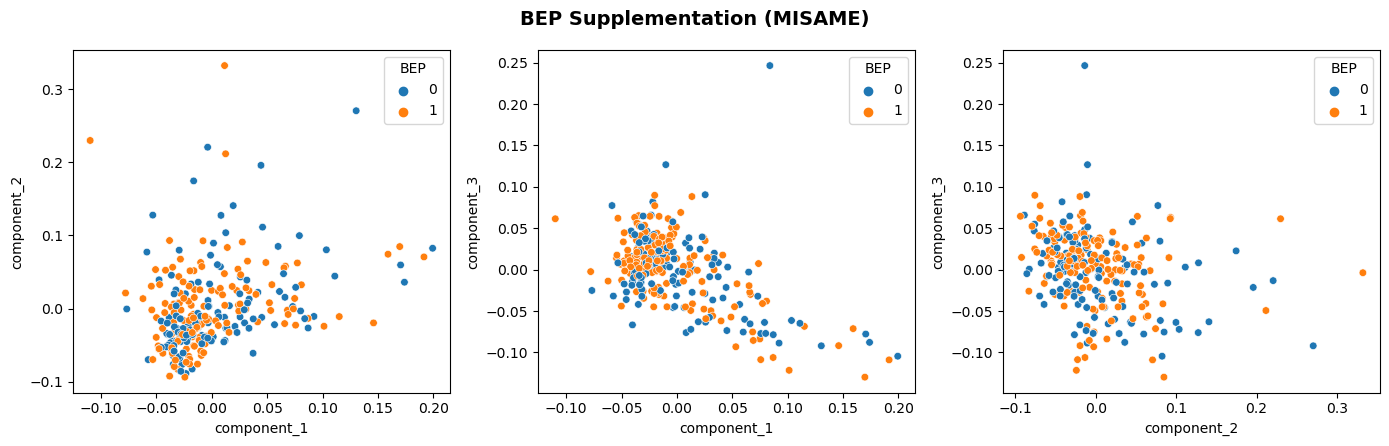

In [27]:
#sapient subset
fig, axn = plt.subplots(1, 3, figsize=(14,4.5))
phenotype = 'BEP' #BEP,WAZ_M04_binary_bins
axn = axn.flatten()
for ax, pcs in zip(axn, [['component_1', 'component_2',], ['component_1', 'component_3'], 
                         ['component_2', 'component_3']]):
    sns.scatterplot(x=pcs[0], y=pcs[1], hue=phenotype, #hue_order=hue_order, 
                    data=ord_plt, s=30, ax=ax)
plt.suptitle("BEP Supplementation (MISAME)", 
             color='black', weight='bold', fontsize=14)
plt.tight_layout()
plt.show()

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:2.917e-01 U_stat=1.046e+04
0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:5.978e-01 U_stat=9.393e+03
0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.348e-01 U_stat=8.739e+03


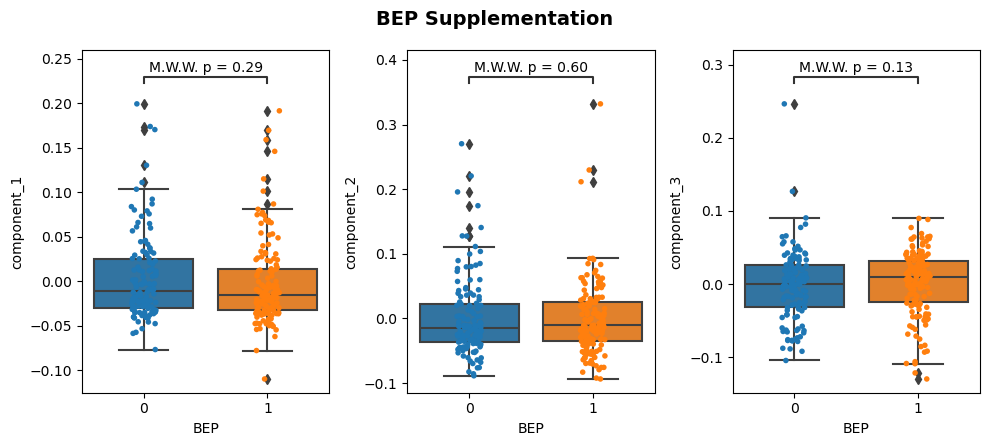

In [25]:
fig, axn = plt.subplots(1, 3, figsize=(10,4.5))
axn = axn.flatten()
phenotype = 'BEP'

for ax, pc in zip(axn, ['component_1', 'component_2', 'component_3']):
    sns.boxplot(x=phenotype, y=pc, data=ord_plt, ax=ax)
    #add points
    sns.stripplot(x=phenotype, y=pc, data=ord_plt, size=4, ax=ax)
    #add significance
    annotator = Annotator(ax, [(0,1)], x=phenotype, y=pc, data=ord_plt)
    annotator.configure(test="Mann-Whitney", text_format='simple').apply_and_annotate()
    
plt.suptitle("BEP Supplementation", 
             color='black', weight='bold', fontsize=14)
plt.tight_layout()

In [39]:
feature_loads['Micronutrients'].sort_values(by='component_3', ascending=False)

,component_1,component_2,component_3
K,-5.024615e-02,-2.908567e-01,9.411076e-01
P,-2.087403e-02,-1.553660e-01,2.649183e-01
Na,9.979074e-01,9.360088e-01,1.664666e-01
Ca,-3.491406e-02,-1.219123e-01,1.277819e-01
B3,1.028887e-04,-1.151473e-04,9.538798e-04
a-tocopherol,4.151809e-04,6.270461e-05,8.008932e-04
PA,-2.823940e-04,-4.511608e-04,3.293244e-04
vitamin A,6.344158e-05,1.206632e-05,1.307136e-04
Zn,1.638034e-07,-7.272016e-07,4.980216e-06
B2,-8.185074e-07,-1.059639e-05,2.870858e-06
